In [5]:
import pandas as pd
import fitter
import scipy.stats as stats
import matplotlib.pyplot as plt
import dill

In [8]:
def get_hauptsprache_kanton(year:str):
    df_hauptspr = pd.read_excel("variable_hauptsprache_pro_kanton/rohdaten/je-d-01.08.01.02.xlsx", sheet_name=year)

    df_hauptspr = df_hauptspr.iloc[4:35, [0,2,4,6,8,10,12,14,16,18,20,22]].replace("X", -1)

    added = df_hauptspr.iloc[:,4:].sum(axis=1)

    df_hauptspr = df_hauptspr.drop(columns=df_hauptspr.columns[4:])

    df_hauptspr["andere"] = added

    df_hauptspr.set_index(df_hauptspr.columns[0], drop=True, inplace=True)

    df_hauptspr.columns = ["Deutsch", "Französisch", "Italienisch", "Andere"]

    df_hauptspr = df_hauptspr.transpose().astype("float").astype("Float64").replace(-1, pd.NA)

    return df_hauptspr

def get_geburtenrate_kanton():

    df_gebRate = pd.read_excel("variable_lebendgeburten_pro_jahr/rohdaten/su-d-01.04.01.01.08.xlsx", sheet_name="Total")

    df_gebRate.set_index(df_gebRate.columns[0], drop=True, inplace=True)

    df_gebRate.columns = df_gebRate.iloc[1,:].values.astype("int").astype("str")

    df_gebRate = df_gebRate.iloc[3:29,:]

    df_gebRate.columns.name = None
    df_gebRate.index.name = None

    return df_gebRate.transpose()

"Hauptsprachen1 nach Kantonen, 2020",Genferseeregion,Waadt,Wallis,Genf,Espace Mittelland,Bern,Freiburg,Solothurn,Neuenburg,Jura,...,Graubünden,Thurgau,Zentralschweiz,Luzern,Uri,Schwyz,Obwalden,Nidwalden,Zug,Tessin
Deutsch,122252.395819,34242.05591,72841.211021,15169.128888,1007154.186483,725072.753094,69618.450588,202103.385346,6706.111986,3653.485469,...,127959.420595,209154.281958,598775.723504,303389.593786,27880.505864,119703.693351,29114.62769,33832.50842,84854.794394,30986.13573
Französisch,1051998.766944,548015.30986,195519.366596,308464.090488,466866.253888,93589.370928,182267.161682,6163.728019,129244.792267,55601.200992,...,2225.206776,2847.85521,12608.517651,5349.507355,215.013574,2747.214749,310.950897,476.784068,3509.047008,14219.089913
Italienisch,69780.368648,33259.570851,12751.656381,23769.141417,55569.764735,27858.974613,6856.214578,10847.5341,8269.271215,1737.77023,...,23739.020479,9723.154578,22411.905176,11303.238367,769.515471,4224.644583,616.206223,906.624031,4591.676502,264683.25762
Andere,438389.052751,211746.72412,61211.11179,165431.216841,306775.090105,159886.774023,56175.84216,50213.200824,32720.460557,7646.161963,...,52609.549576,47777.56619,153665.500355,74954.501126,4189.789533,28577.321095,4465.538248,5502.192785,35485.916664,50971.824819


C:\Users\tobia\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4530: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]
C:\Users\tobia\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:4530: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


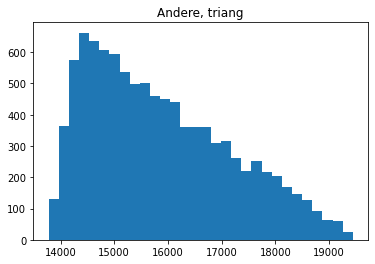

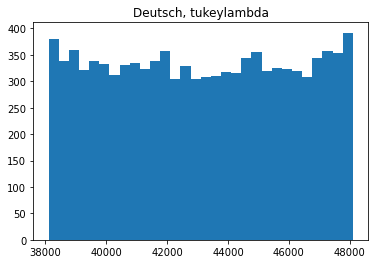

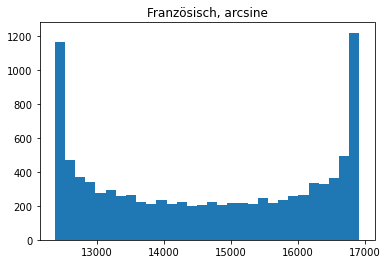

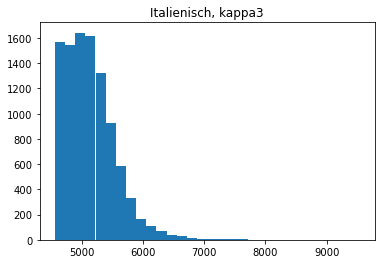

In [7]:
df_geburtenRate = get_geburtenrate_kanton()

df_hauptsprache_mean = get_hauptsprache_kanton("2010")

for year in range(2011, 2021):
    df_hs = get_hauptsprache_kanton(str(year))

    df_hauptsprache_mean = pd.concat((df_hauptsprache_mean, df_hs))

df_mean_hauptsprache = df_hauptsprache_mean.groupby(df_hauptsprache_mean.index).mean()

df_mean_hauptsprache_percent = df_mean_hauptsprache.apply(lambda x: x / x.sum())


dict_birthRate_lang_distribution = {}
for year, row in df_geburtenRate.iterrows():
    dict_birthRate_languages = {}

    #iteriere über kantone
    for kanton, birthRate in row.iteritems():
        if kanton in df_mean_hauptsprache_percent.columns:
            #iteriere über sprachenanteil der kantone
            for sprache, langPercent in df_mean_hauptsprache_percent[kanton].iteritems():
                dict_birthRate_languages[sprache] = dict_birthRate_languages.get(sprache, 0) + birthRate * langPercent

    for key, value in list(dict_birthRate_languages.items()):
        item = dict_birthRate_lang_distribution.get(key, [])
        item.append(value)
        dict_birthRate_lang_distribution[key] = item

dict_distributions = {}
for sprache, values in dict_birthRate_lang_distribution.items():
    f = fitter.Fitter(values, timeout=5)
    f.fit()

    dict_distributions[sprache] = f.get_best()


for sprache, dist in dict_distributions.items():
    obj = getattr(stats, list(dist.keys())[0])

    dist_vals = obj.rvs(*dist[list(dist.keys())[0]], size=10000)

    plt.hist(dist_vals, bins=30)
    plt.title(sprache + ", " + str(list(dist.keys())[0]))
    plt.show()

dill.dump(dict_distributions, open("districutions_nach_sprache.pick", mode='wb'))